#Big Data Doesn't Exist

The recent opinion piece [Big Data Doesn't Exist](http://techcrunch.com/2015/09/10/big-data-doesnt-exist/) on Tech Crunch by Slater Victoroff is an interesting discussion about the usefulness of data both big and small.  Slater joins me this episode to discuss and expand on this discussion.

Slater Victoroff is CEO of [indico Data Solutions](https://indico.io/), a company whose services turn raw text and image data into human insight.  He, and his co-founders, studied at Olin College of Engineering where indico was born.  indico was then accepted into the "Techstars Accelarator Program" in the Fall of 2014 and went on to raise $3M in seed funding.  His recent essay "Big Data Doesn't Exist” received a lot of traction on TechCrunch, and I have invited Slater to join me today to discuss his perspective and touch on a few topics in the machine learning space as well.

During the interview, two noteworthy papers are mentioned and discussed. [Scaling to Very Very Large Corpora for Natural Language Disambiguation](http://ucrel.lancs.ac.uk/acl/P/P01/P01-1005.pdf) by Banko and Brill, and [Transfer Learning](ftp://ftp.cs.wisc.edu/machine-learning/shavlik-group/torrey.handbook09.pdf) by Torrey and Shavlik.  We also mentioned the [ImageNet](http://www.image-net.org/) dataset and the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) dataset.

The episode winds up with a discussion of [indico](https://indico.io/) - Slater's company.  For fun, I tried out their API for some analysis on the show notes of previous episodes of Data Skeptic.  That analysis can be found at the end of the show notes.

Lastly, Slater mentioned a new project from indico called Thumbprint which performs quick analysis on twitter streams.  You can see the results for [@DataSkeptic](https://indico.io/thumbprint/report?id=54690ee171) or [try your own](https://indico.io/thumbprint/).

<audio src="<? echo($url); ?>" preload="auto" />

##Trying indico API

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ConfigParser
import json
import indicoio
import requests
import xmltodict
from BeautifulSoup import BeautifulSoup
import time
import pickle

In [8]:
propertiesFile = "indico.properties"
cp = ConfigParser.ConfigParser()
cp.readfp(open(propertiesFile))

api_key = cp.get('config', 'api_key')
indicoio.config.api_key = api_key

In [21]:
fname = 'feed.xml'
url = 'http://dataskeptic.com/feed.rss'

if not(os.path.isfile(fname)):
    print 'fetching'
    r = requests.get(url)
    f = open(fname, 'wb')
    f.write(r.text.encode('utf-8'))
    f.close()

with open(fname) as fd:
    xml = xmltodict.parse(fd.read())

In [91]:
episodes = xml['rss']['channel']['item']
descriptions = []
descToTitle = {}
descToNum = {}
l = len(episodes)
for episode in episodes:
    enclosure = episode['enclosure']
    desc = episode['description']
    desc = BeautifulSoup(desc).text
    descriptions.append(desc)
    descToTitle[desc] = episode['title']
    descToNum[desc] = l
    l = l - 1

In [55]:
responses = {}
for desc in descriptions:
    resp = indicoio.analyze_text(desc, apis=['sentiment_hq', 'political', 'text_tags', 'keywords'])
    responses[desc] = resp
    time.sleep(.5)

In [56]:
pickle.dump(responses, open('cache_responses.pkl', 'wb'))

## Keyword Extraction

The plots below are the three keywords extracted by indico when given the (often brief) show notes of every episode of Data Skeptic.  I don't think I'll directly stick these in an SEM campaign without some additional steps of analysis, but these look pretty useful for finding themes, and the responses come back fast enough for use in an online algorithm, despite my offline use here.

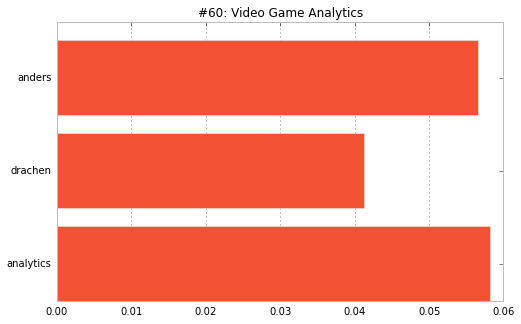

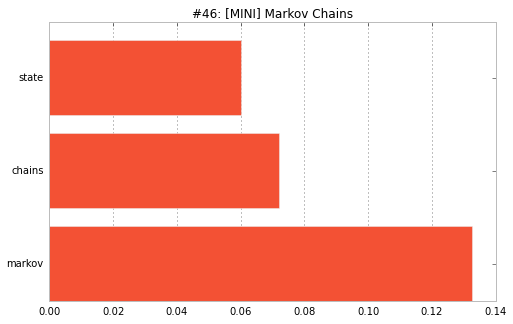

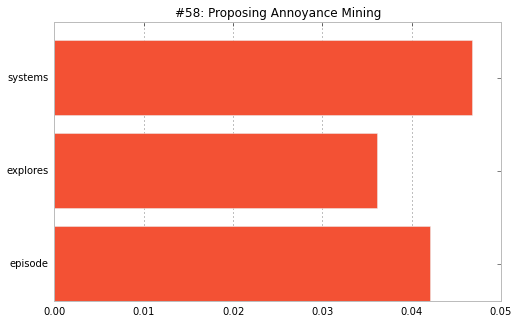

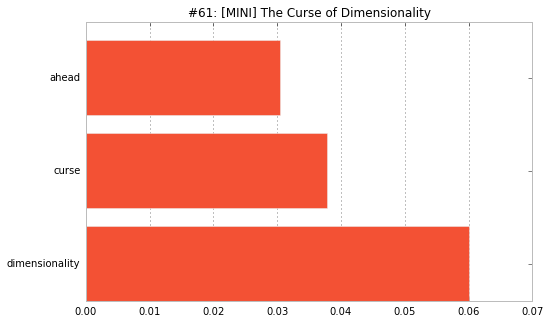

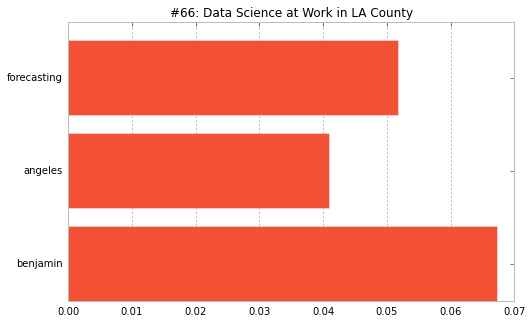

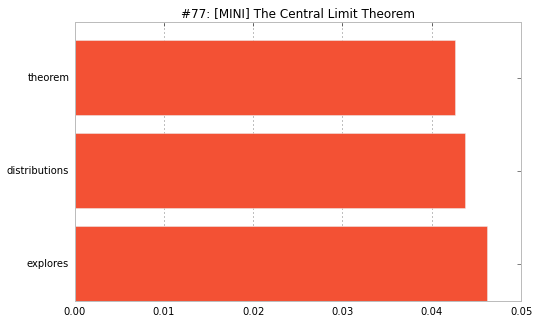

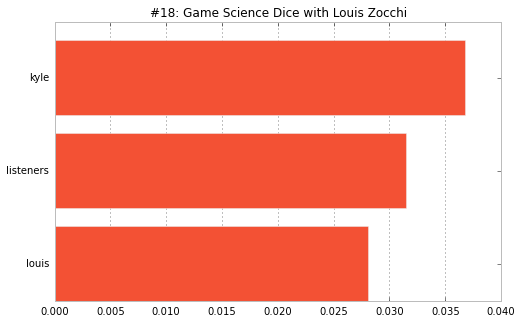

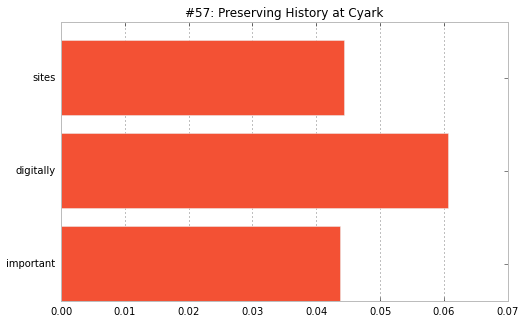

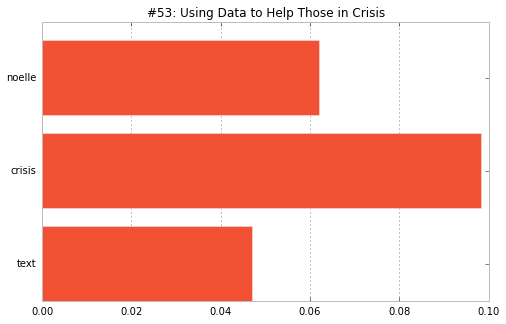

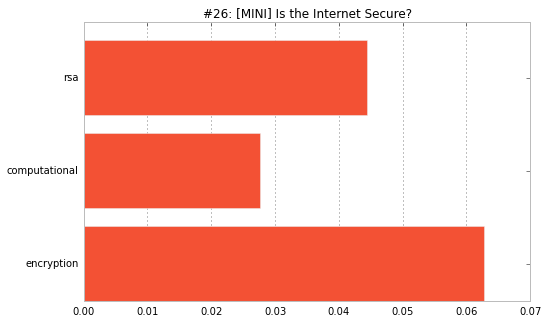

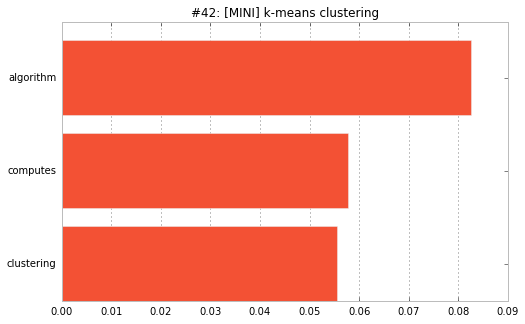

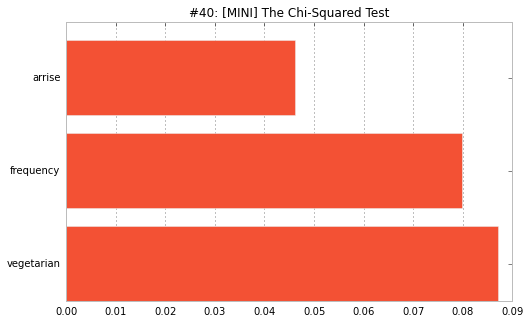

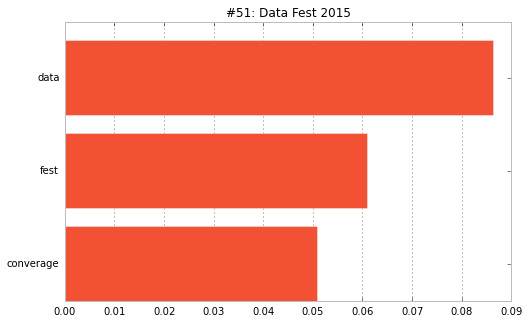

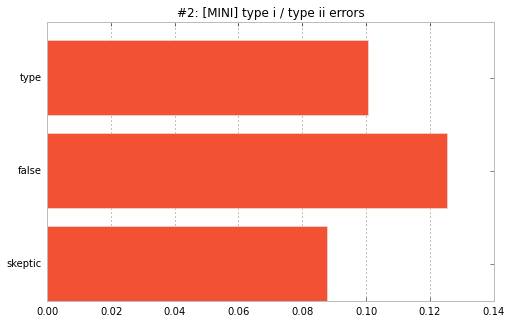

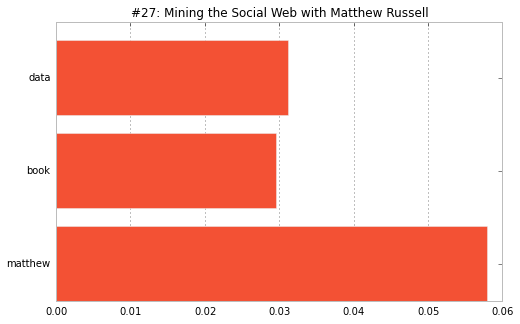

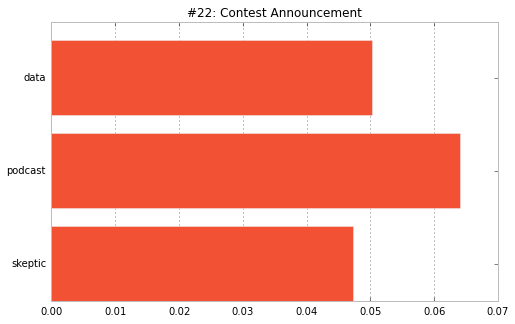

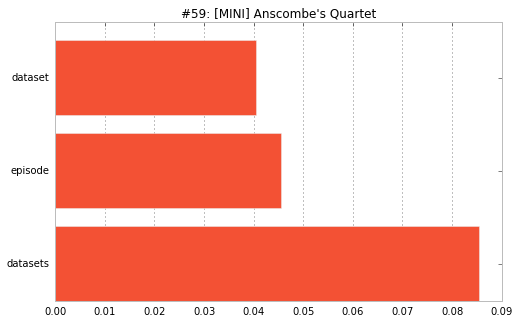

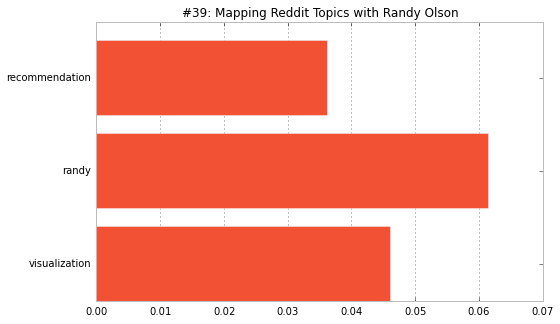

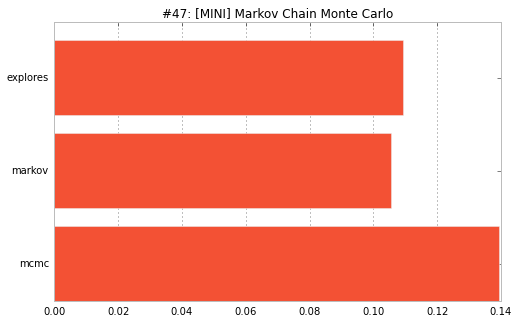

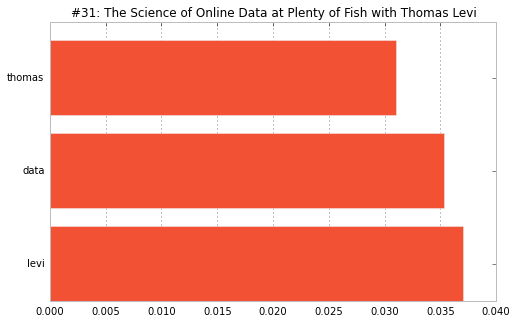

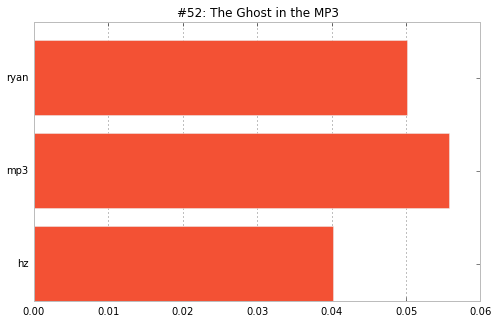

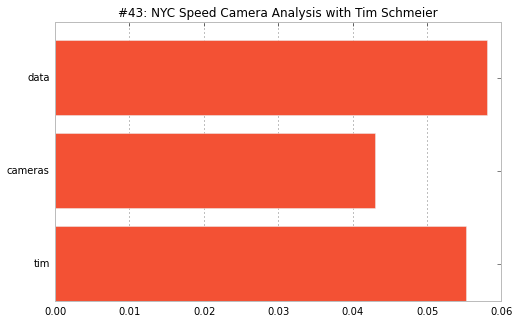

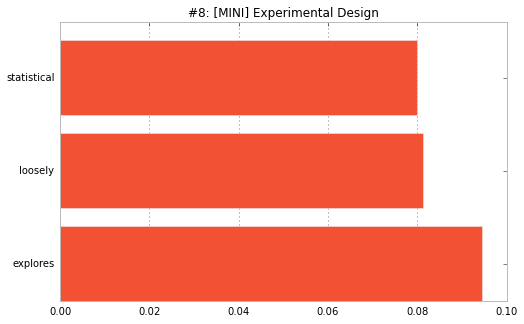

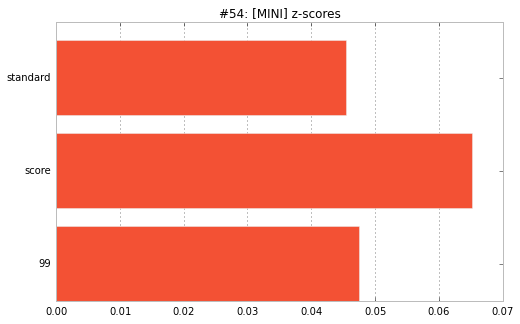

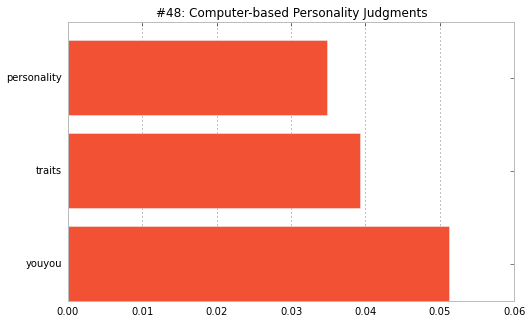

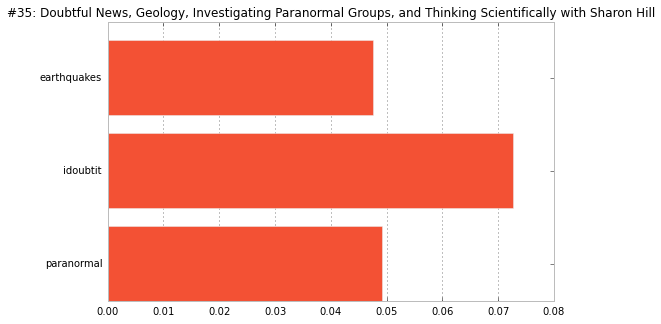

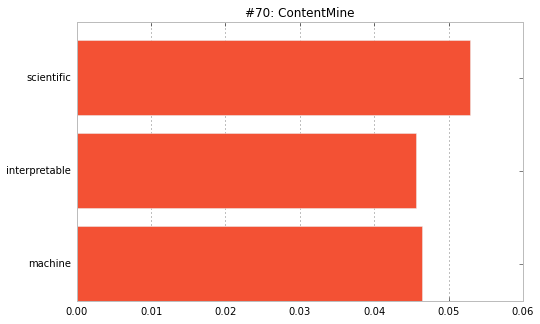

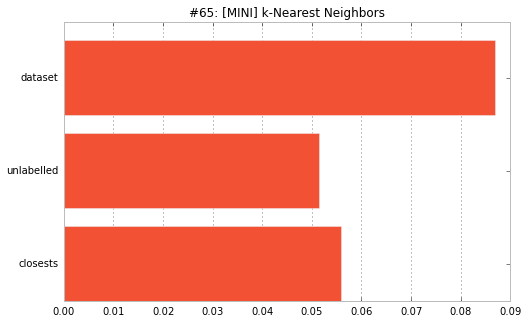

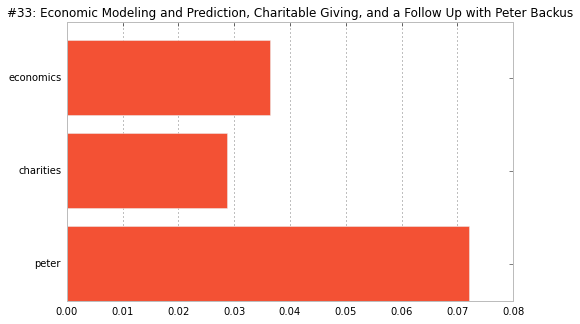

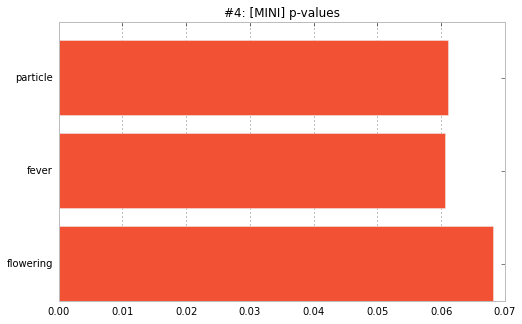

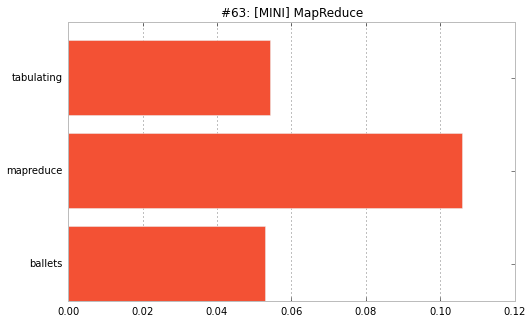

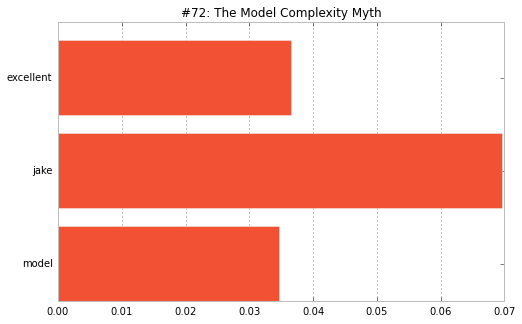

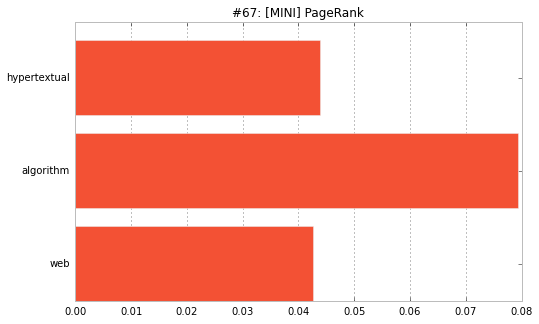

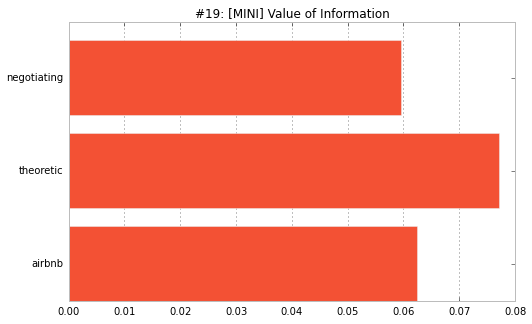

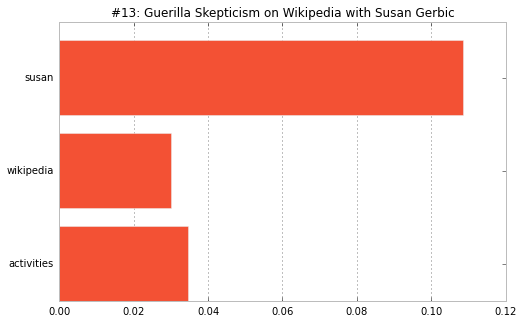

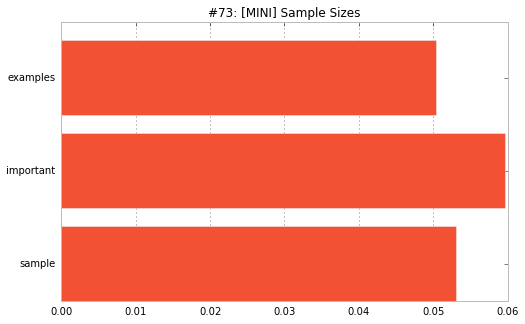

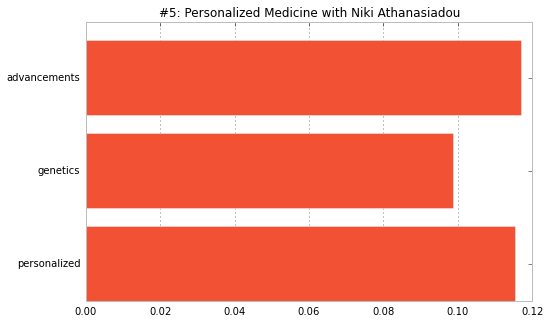

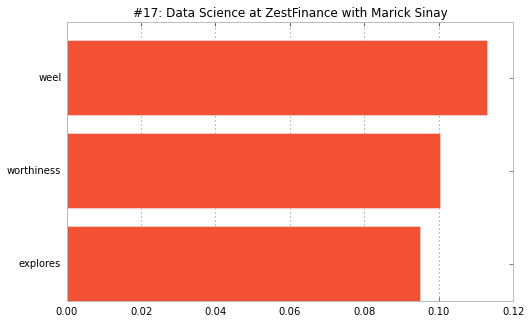

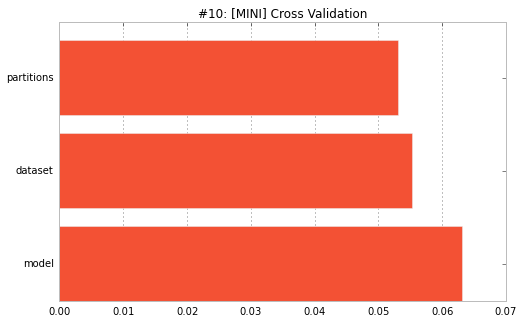

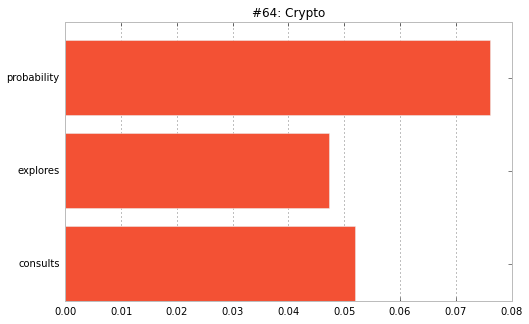

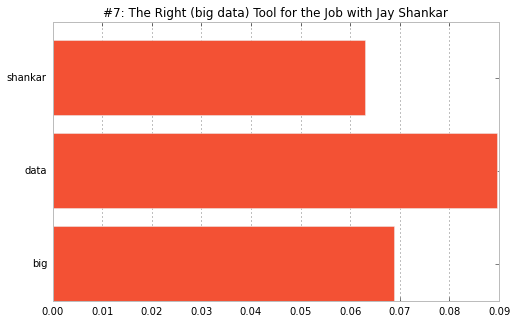

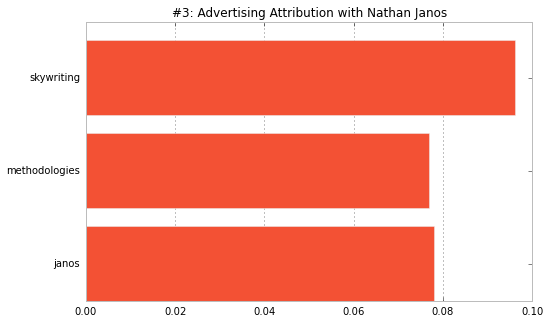

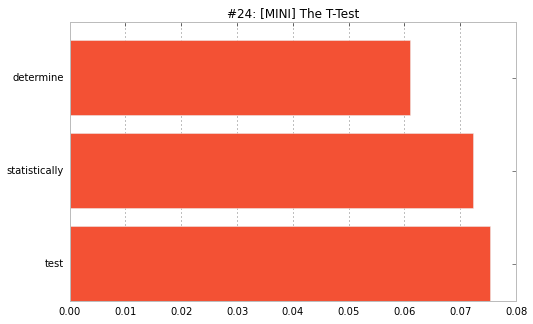

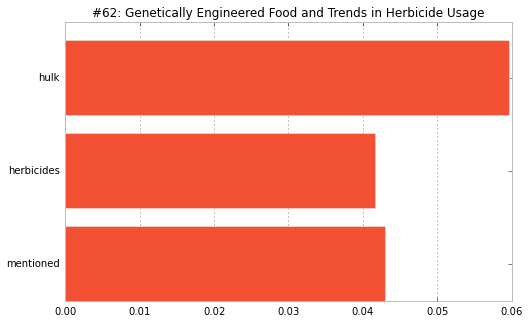

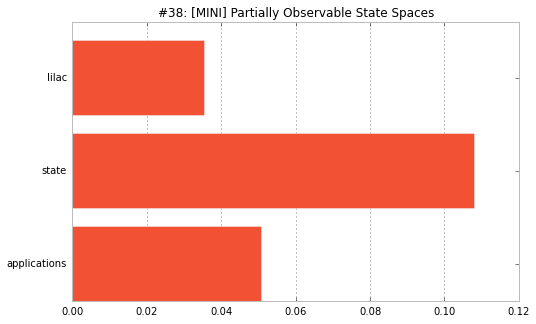

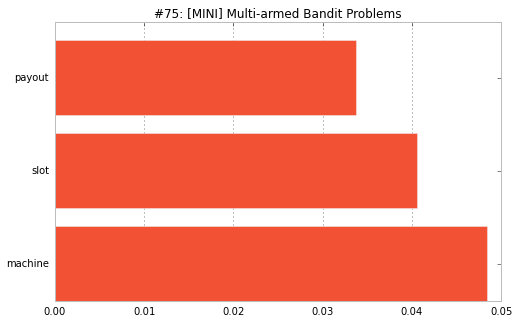

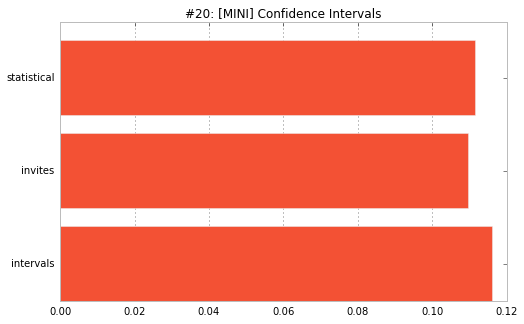

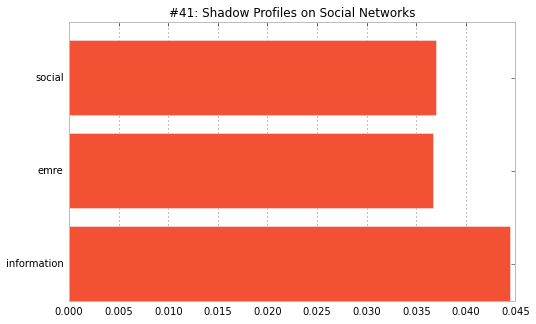

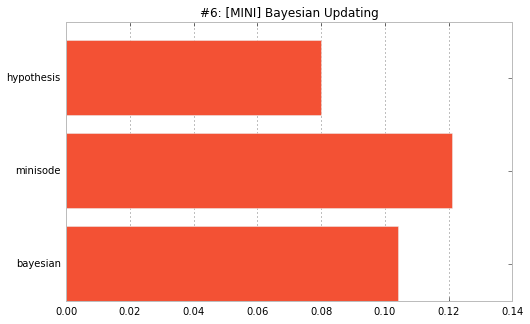

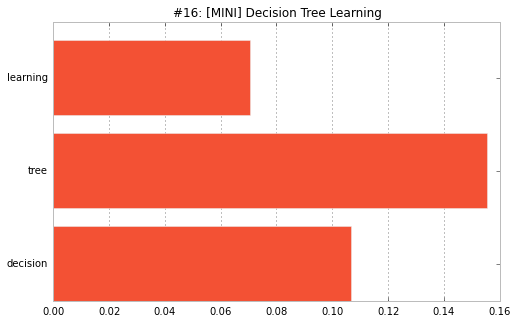

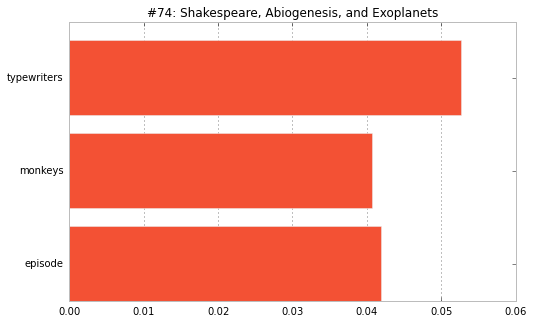

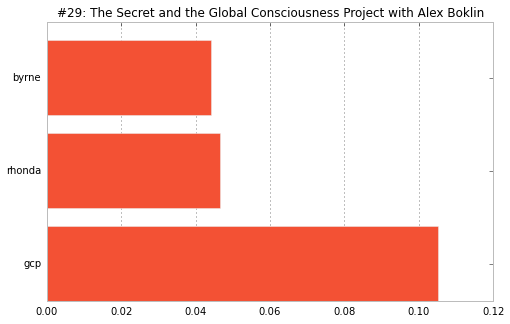

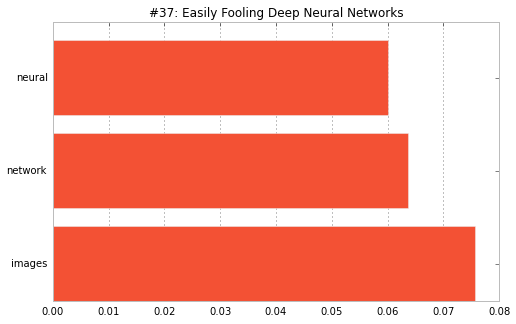

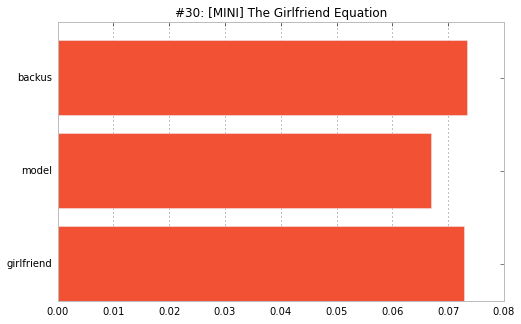

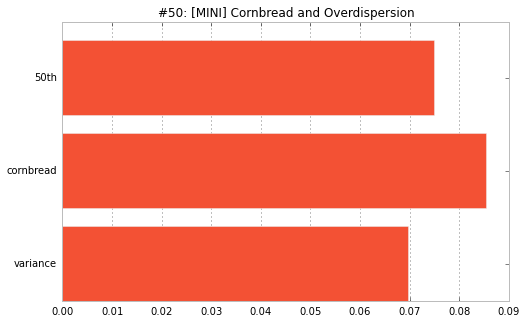

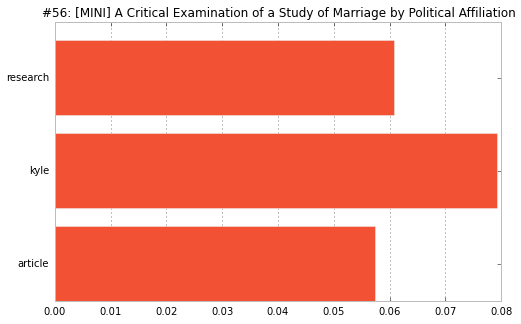

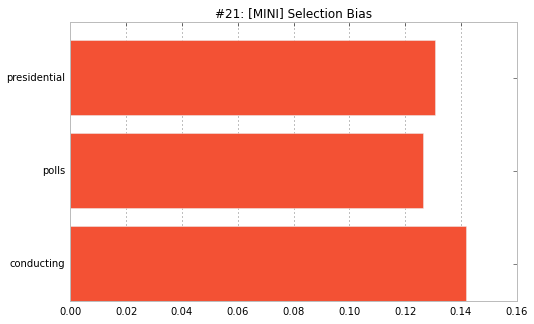

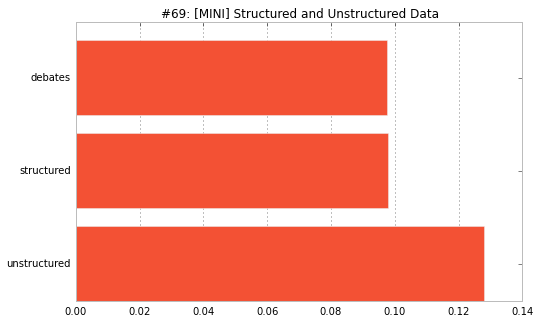

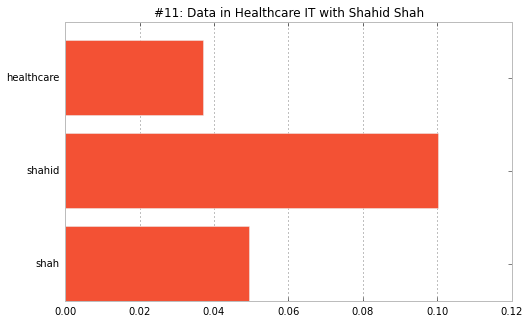

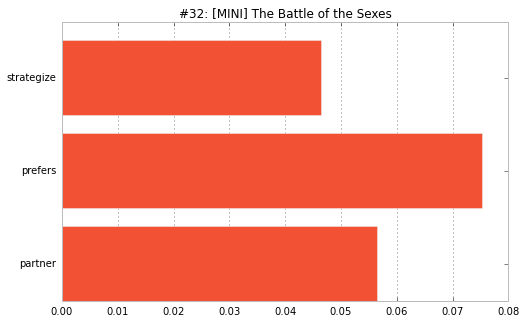

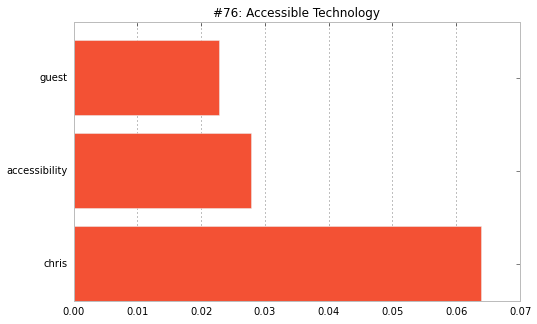

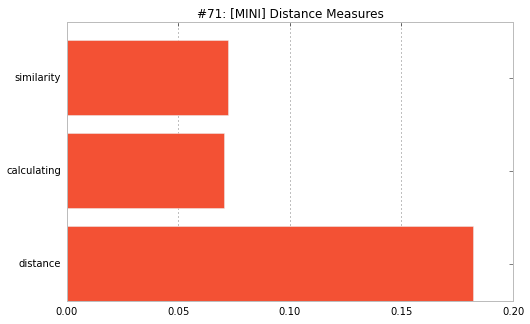

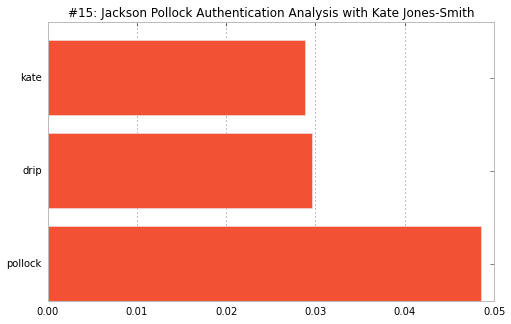

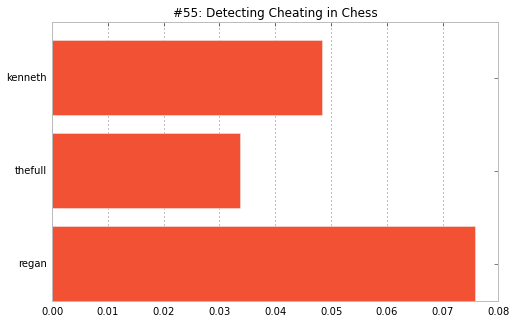

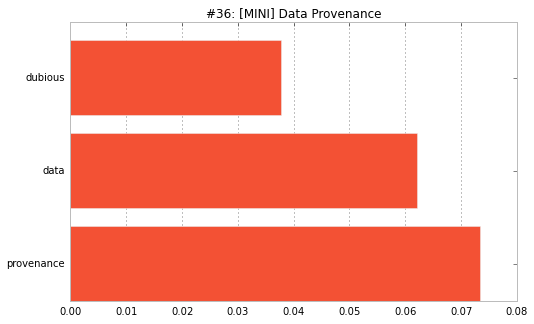

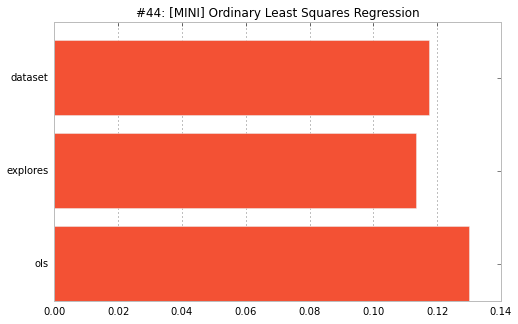

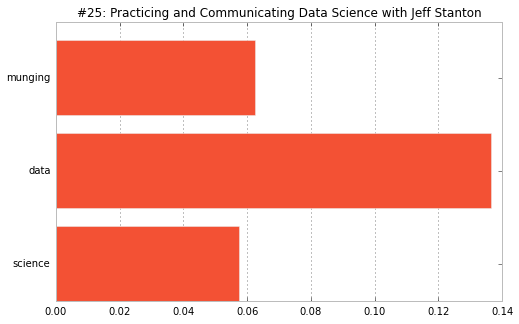

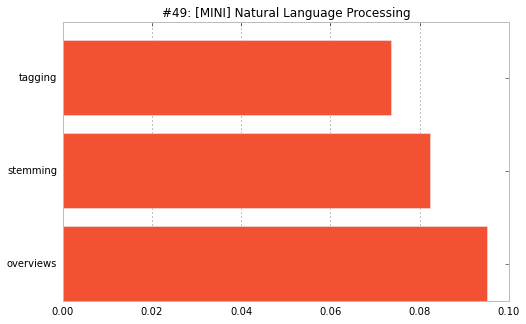

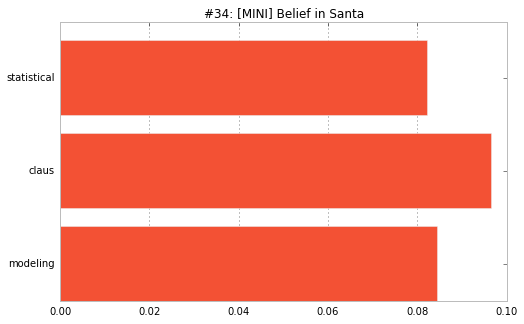

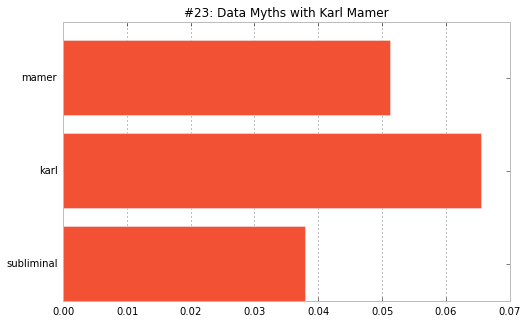

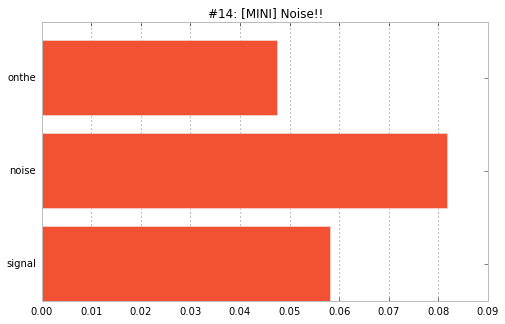

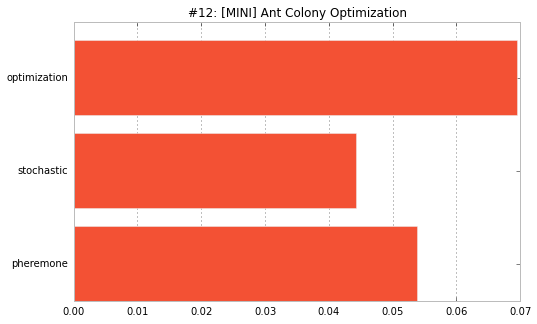

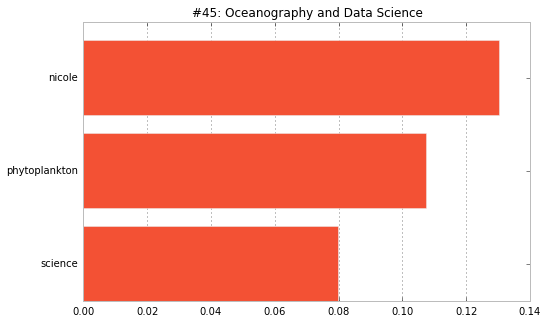

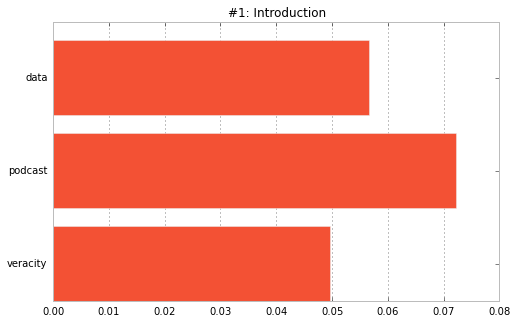

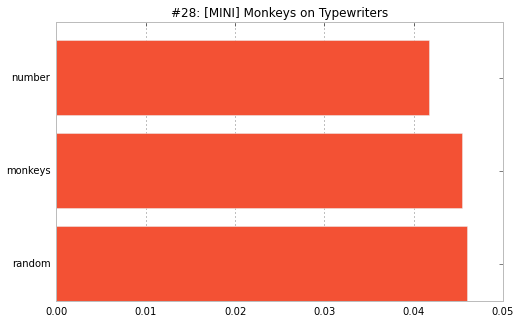

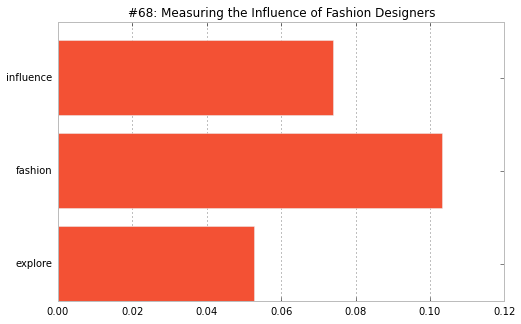

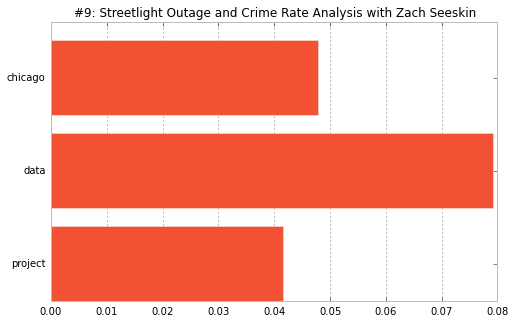

In [146]:
for desc in responses.keys():
    r = responses[desc]
    title = descToTitle[desc]
    keywords = zip(*r['keywords'].items())
    x = np.arange(len(keywords[0]))
    plt.figure(figsize=(8,5))
    plt.barh(x, keywords[1])
    plt.yticks(x + 0.4, keywords[0])
    plt.gca().yaxis.grid(False)
    plt.title('#' + str(descToNum[desc]) + ': ' + title)
    plt.show()

## Sentiment Analysis

I almost skipped performing sentiment analysis, since I express very little sentiment in the notes.  I try to keep it merely factual.  Nonetheless, the plot below shows the sentiment ratings I got back, mostly positive, which seems reasonable to me.  Perhaps closer to neutral would have been in line with my expectations, but my notes do tend to offer praise for the work of my guests, so I'm guessing that's what's really being detected.

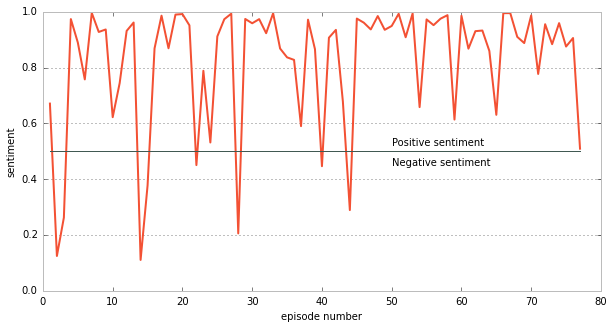

In [112]:
sentiments = []
titles = []
nums = []
for desc in responses.keys():
    r = responses[desc]
    titles.append(descToTitle[desc])
    sentiments.append(r['sentiment_hq'])
    nums.append(descToNum[desc])

df = pd.DataFrame({'sentiment': sentiments, 'title': titles, 'num': nums})
df.sort('num', inplace=True)

plt.figure(figsize=(10,5))
plt.plot(df['num'], df['sentiment'], linewidth=2)
plt.plot(df['num'], np.ones(df.shape[0]) * .5)
plt.ylim(0,1)
plt.text(50,.52,"Positive sentiment")
plt.text(50,.45,"Negative sentiment")
plt.gca().xaxis.grid(False)
plt.xlabel('episode number')
plt.ylabel('sentiment')
plt.show()

But what are those low sentiment cases?  What was going on in those episodes?  You can see the negative sentiment episodes listed below.  "Jackson Pollock Authentication Analysis" was a discussion of a response paper critical of earlier findings, so that makes perfect sense to me.  A few others seem to focus around some statistical episodes where things like "error" and "fail to reject the null hypothesis" are probably mentioned, tuning some of these towards negative polarity.

In [113]:
df[df['sentiment'] < .5]

,num,sentiment,title
13,2,0.124783,[MINI] type i / type ii errors
41,3,0.262456,Advertising Attribution with Nathan Janos
70,14,0.110624,[MINI] Noise!!
62,15,0.377653,Jackson Pollock Authentication Analysis with K...
15,22,0.450536,Contest Announcement
74,28,0.205629,[MINI] Monkeys on Typewriters
11,40,0.446553,[MINI] The Chi-Squared Test
65,44,0.289322,[MINI] Ordinary Least Squares Regression


## Text Tags

The last feature of the indico API I looked at was text tags.  Of their taxonomy, I score highest in math, which does indeed strike me as the most appropriate weighting for the show.

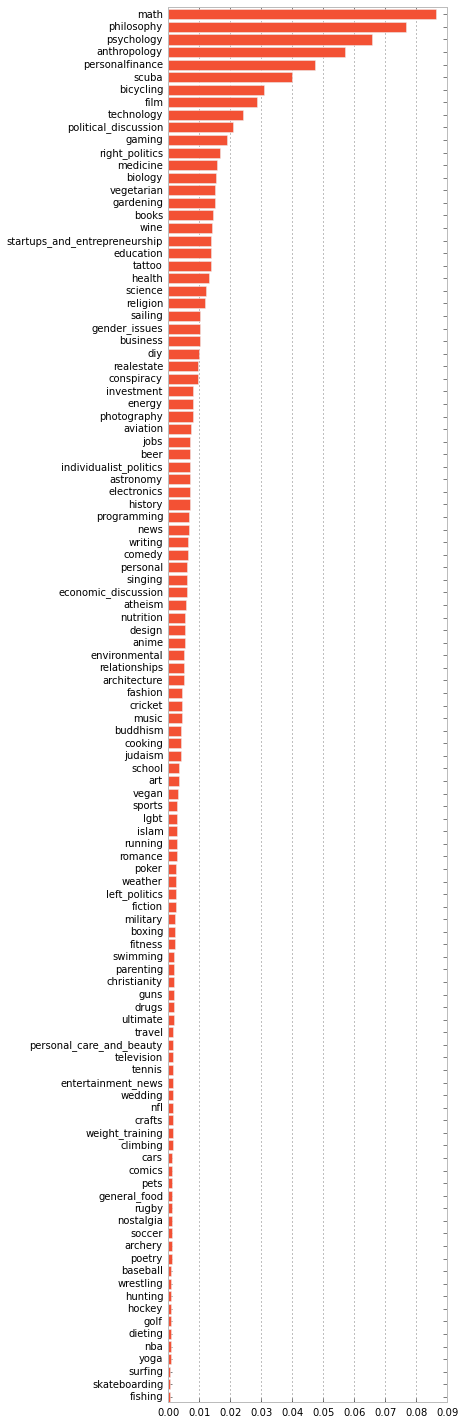

In [145]:
values = []
for desc in responses.keys():
    r = responses[desc]
    items = zip(*r['text_tags'].items())
    values.append(items[1])

df = pd.DataFrame(values)
df.columns = items[0]
df2 = pd.DataFrame(df.mean())
df2.columns = ['weight']
df2.sort('weight', inplace=True)
x = np.arange(df2.shape[0])
plt.figure(figsize=(5,25))
plt.barh(x, df2['weight'])
plt.yticks(x+0.4, df2.index)
plt.ylim(0, len(x))
plt.gca().yaxis.grid(False)
plt.show()